In [1]:
#Importing the necessary scripts
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.utils import *

#Importing the necessary packages
import numpy as np


In [2]:
#Create an embeddings object with the embeddings file
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)


Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [3]:
# From the embeddings object, get the vectors, the word2idx dictionary, the vocab list, and the dict_vectors dictionary
# Because the gensim embeddings carry no information on the file, we need to use the built-in function from gensim to get the vocab in descending frequency.
glove.model.sort_by_descending_frequency()
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

#print the first 20 words in the vocab
print(vocab[:20])

#Print the shape of the vectors
print("vectors shape", vectors.shape)

#Print a boolean to check if there are any NaNs in the vectors
print("Missing values in vectors?", np.isnan(vectors).any())


['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
vectors shape (400000, 300)
Missing values in vectors? False


In [4]:
# Getting a limited vocabulary to debias the embeddings.
vocab_nopunct, vectors_nopunct, word2idx_nopunct, dict_vec_nopunct = glove.limit_vocab(vectors, word2idx, vocab)


100%|██████████| 400000/400000 [00:00<00:00, 617673.93it/s]


Size of limited vocabulary: 327185


 ## Hard-Debias Algorithm

 #### Preliminaries

In [5]:
# Cleaning the vocabulary from pounctuation and numbers
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(
    vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 617050.56it/s]


Size of limited vocabulary: 327185


In [6]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], 
        ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'],
        ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], 
        ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], 
        ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], 
        ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], 
        ["brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman","congresswoman"], 
        ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"],
        ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], 
        ["gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], 
        ["his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"],
        ["men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], 
        ["twin_brother", "twin_sister"]]}

#Words taken from Wang et al. to enrich the equalizing pairs
female_vocab = ['countrywoman',  'witches',  'maidservant',  'mothers',  'diva',  'actress',  'spinster',  'mama',  'duchesses',  'countrywomen',  'hostesses',  'suitors',  'menopause',  'clitoris',  'princess',  'governesses',  'abbess',  'women',  'widow',  'ladies',  'sorceresses',  'madam',  'brides',  'baroness',  'niece',  'widows',  'lady',  'sister',  'brides',  'nun',  'obstetrics',  'her',  'marchioness',  'princesses',  'empresses',  'mare',  'chairwoman',  'convent',  'priestesses',  'girlhood',  'ladies',  'queen',  'gals',  'mommies',  'maid',  'spokeswoman',  'seamstress',  'cowgirls',  'chick',  'spinsters',  'empress',  'mommy',  'gals',  'enchantress',  'gal',  'motherhood',  'estrogen',  'godmother',  'strongwoman',  'goddess',  'matriarch',  'aunt',  'chairwomen',  'maam',
                'sisterhood',  'hostess',  'estradiol',  'wife',  'mom',  'stewardess',  'females',  'spokeswomen',  'ma',  'belle',  'minx',  'maiden',  'witch',  'miss',  'nieces',  'mothered',  'cow',  'belles',  'granddaughter',  'fiancees',  'stepmothers',  'grandmothers',  'schoolgirl',  'hen',  'granddaughters',  'bachelorette',  'camerawoman',  'moms',  'her',  'mistress',  'lass',  'policewoman',  'nun',  'actresses',  'saleswomen',  'girlfriend',  'councilwoman',  'lady',  'stateswoman',  'maternal',  'lass',  'landlady',  'ladies',  'wenches',  'sorority',  'duchess',  'ballerina',  'chicks',  'fiancee',  'fillies',  'wives',  'she',  'businesswoman',  'masseuses',  'heroine',  'doe',  'girlfriends',  'queens',  'sisters',  'stepmother',  'daughter',  'cowgirl',  'daughters',  'soprano',
                'saleswoman',  'mistress',  'nuns',  'headmistresses',  'lasses',  'congresswoman',  'housewife',  'priestess',  'abbesses',  'toque',  'sororities',  'stewardesses',  'filly',  'czarina',  'stepdaughters',  'herself',  'girls',  'lionesses',  'lady',  'vagina',  'hers',  'masseuse',  'cows',  'aunts',  'wench',  'toques',  'wife',  'lioness',  'sorceress',  'mother',  'lesbians',  'female',  'waitresses',  'ovum',  'ovary',  'stepdaughter',  'businesswomen',  'heiress',  'waitress',  'headmistress',  'woman',  'governess',  'bride',  'grandma',  'bride',  'gal',  'lesbian',  'ladies',  'girl',  'grandmother',  'mare',  'hens',  'nuns',  'maidservants',  'heroines']
male_vocab = ['countryman',  'wizards',  'manservant',  'fathers',  'divo',  'actor',  'bachelor',  'papa',  'dukes',  'countrymen',  'hosts',  'airmen',  'andropause',  'penis',  'prince',  'governors',  'abbot',  'men',  'widower',  'gentlemen',  'sorcerers',  'sir',  'bridegrooms',  'baron',  'nephew',  'widowers',  'lord',  'brother',  'grooms',  'priest',  'andrology',  'his',  'marquis',  'princes',  'emperors',  'stallion',  'chairman',  'monastery',  'priests',  'boyhood',  'fellas',  'king',  'dudes',  'daddies',  'manservant',  'spokesman',  'tailor',  'cowboys',  'dude',  'bachelors',  'emperor',  'daddy',  'guys',  'enchanter',  'guy',  'fatherhood', 
                'androgen',  'godfather',  'strongman',  'god',  'patriarch',  'uncle',  'chairmen',  'sir',  'brotherhood',  'host',  'testosterone',  'husband',  'dad',  'steward',  'males',  'spokesmen',  'pa',  'beau',  'stud',  'bachelor',  'wizard',  'sir',  'nephews',  'fathered',  'bull',  'beaus',  'grandson',  'fiances',  'stepfathers',  'grandfathers',  'schoolboy',  'rooster',  'grandsons',  'bachelor',  'cameraman',  'dads',  'him',  'master',  'lad',  'policeman',  'monk',  'actors',  'salesmen',  'boyfriend',  'councilman',  'fella',  'statesman',  'paternal',  'chap',  'landlord',  'lords',  'blokes',  'fraternity',  'duke',  'dancer',  'dudes',  'fiance',
                'colts',  'husbands',  'he',  'businessman',  'masseurs',  'hero',  'deer',  'boyfriends',  'kings',  'brothers',  'stepfather',  'son',  'cowboy',  'sons',  'baritone',  'salesman',  'paramour',  'monks',  'headmasters',  'lads',  'congressman',  'househusband',  'priest',  'abbots',  'beard',  'fraternities',  'stewards',  'colt',  'czar',  'stepsons',  'himself',  'boys',  'lions',  'gentleman',  'penis',  'his',  'masseur',  'bulls',  'uncles',  'bloke',  'beards',  'hubby',  'lion',  'sorcerer',  'father',  'gays',  'male',  'waiters',  'sperm',  'prostate',  'stepson',  'businessmen',  'heir',  'waiter',  'headmaster',  'man',  'governor',  'bridegroom', 
                'grandpa',  'groom',  'dude',  'gay',  'gents',  'boy',  'grandfather',  'gelding',  'roosters',  'priests',  'busboy',  'heros']

#added the gendered pairs to the equalizing list (equalizing_lists['gender'] if the pairs are not there already
gendered_pairs = list(zip(male_vocab, female_vocab))
list_pairs = [tuple for tuple in gendered_pairs if tuple not in equalizing_lists['gender']]
equalizing_lists['gender'] = equalizing_lists['gender']+list_pairs

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.



 #### Gender Debiasing

In [7]:
#putting the def_sets on the right format for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])



In [8]:
#Getting the debiased embeddings with the specifications obtained before 
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender,deb_dict_gender = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             normalize_dir=False,
                             normalize='after',
                             centralizing=True)


Length of vectors set: 22
Running PCA with 1 components


 ## Evaluation

In [9]:
#Importing the necessary scripts
from Scripts.Visualization import *
from Scripts.Evaluation import *
import pandas as pd


 ### Gender Bias Pre-Post
 Let's take a look first at the results of the algorithm with respect to the occupation words. I also plot the clusters and see that, indeed, it appears that the feminine and masculine words are mingling together.

In [13]:
# To compute the simple gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
simple_gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

#And a dictionary of the debiased scores
gender_bias_after_debiasing=compute_gender_simple_bias(deb_dict_gender, he_embed, she_embed)


In [12]:
#To compute the direct gender bias, we need to compute the direct bias per word. 
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)

#Dictionary with direct bias
direct_gender_bias_original = compute_direct_bias(
    dict_vec_cleaned, vocab_cleaned, gender_direction)

#Dictionary with direct bias after debiasing
direct_gender_bias_debiased = compute_direct_bias(
    deb_dict_gender, neutral_words, gender_direction)



Length of vectors set: 22
Running PCA with 1 components


In [14]:
#Testing the scores in the occupations lists
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']
bias_df=get_bias_score_df_from_list(simple_gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,deb_vocab_gender)
plot_bias_bar(bias_df, "Gender bias on occupations (original vs debiased)", "Occupations")


precision 1.0
precision 0.315


(0.315, <AxesSubplot:title={'center':'Debiased_GloVe'}>)

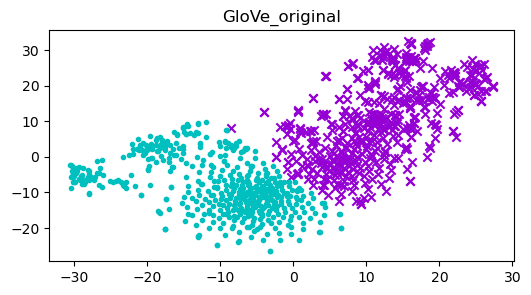

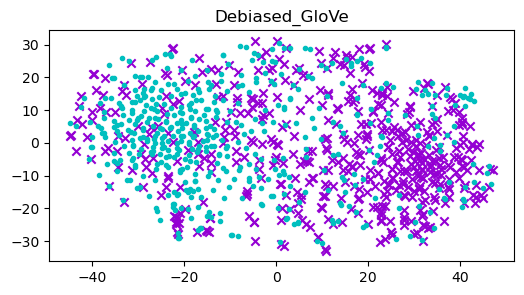

In [15]:
#Also, to test, whether the algorithm is working correctly, we can check the clusters of biased words:
# at first the clusters should be linearly separable, and after debiasing, they should be mixed
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(simple_gender_bias_original, def_sets['gender'], 500, word2idx)

#Clustering with k-means to visualize clusters in original embeddings
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      np.array(gendered_vectors), 'GloVe_original', y_true, random_state=42)

#Clustering with k-means to visualize clusters in debiased embeddings
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, deb_vect_gender, deb_word2idx_gender)

cluster_and_visualize(male_words + female_words, np.array(gendered_debiased_vectors),
                      'Debiased_GloVe', y_true, random_state=42)



 ###  Random Words: bias scores and neighbors
 To get an idea of the effects of the debiasing algorithm in the vector space, we'll study the neighbors of 50 random words chosen from the 10000 more frequent words (the first in the vocabulary).

In [16]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=50)

#setting parameters for the gensim method "most_similar"
topn = 3



In [17]:
random_words


array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland', 'withdrawn', 'parole', 'listened', 'rugby',
       'garbage', 'fears', 'neighboring', 'personalities', 'deceased',
       'political', 'concluded', 'operate', 'reflected', 'controlled',
       'symbols', 'session', 'female', 'revolutionary', 'consensus',
       'roc', 'albania', 'carpet', 'evaluate', 'destinations', 'colombia',
       'physicians', 'lobbyists', 'travels', 'laura', 'loyalty'],
      dtype='<U18')

In [18]:
#Getting the gender bias score for the random words list
bias_df = get_bias_score_df_from_list(
    simple_gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df, "Gender bias on random_words (original vs debiased)", "Random_words")



In [19]:
#First let's get the 50 nearest neighbors of the random words in the original embeddings
k_neigh= get_k_nearest_neighbors(random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned,
                                 word2idx_cleaned, k=50)
#let's put them on a list
list_neigh = get_list_neighbors(k_neigh)


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


With the list of original neighbors, we can take a look at the proportion of original neighbors laying on the new 50-vicinity, as well as for the distances of these words to the random words pre-and post debiasing.

In [20]:
from Scripts.Evaluation import get_frequency_original_neighbors

#We find the frequency of the original neighbors in the debiased embeddings
neig_freq2=get_frequency_original_neighbors(
    random_words, k_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)

df_freq = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])



50it [01:19,  1.59s/it]


In [23]:
from Scripts.Visualization import plot_frequency_original_neighbors
#Let's get a plot of the results
plot_frequency_original_neighbors(df_freq, "Frequency of original neighbors in debiased embeddings", 'Random words')



In [24]:
#Let's look at the distances to the original neighbors pre- and post- debiasing
distances_original, distances_debiased = get_distance_to_neighbors(k_neigh,
                                                                   dict_vec_cleaned, deb_dict_gender)

df_neigh_distances=get_df_distances(distances_original,distances_debiased)

#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#now add a column of the difference between the two mean distances
df_average['difference']=abs(df_average['distance_original']-df_average['distance_debiased'])
df_average=df_average.sort_values(by='difference', ascending=True)

df_average=df_average.reset_index()

from Scripts.Visualization import plot_average_distance
plot_average_distance(
    df_average, 'Average cosine distance to neighbors before and after debiasing', 'Words Chosen at Random'
)

The original clusters do seem to be disentangled in the new embeddings.

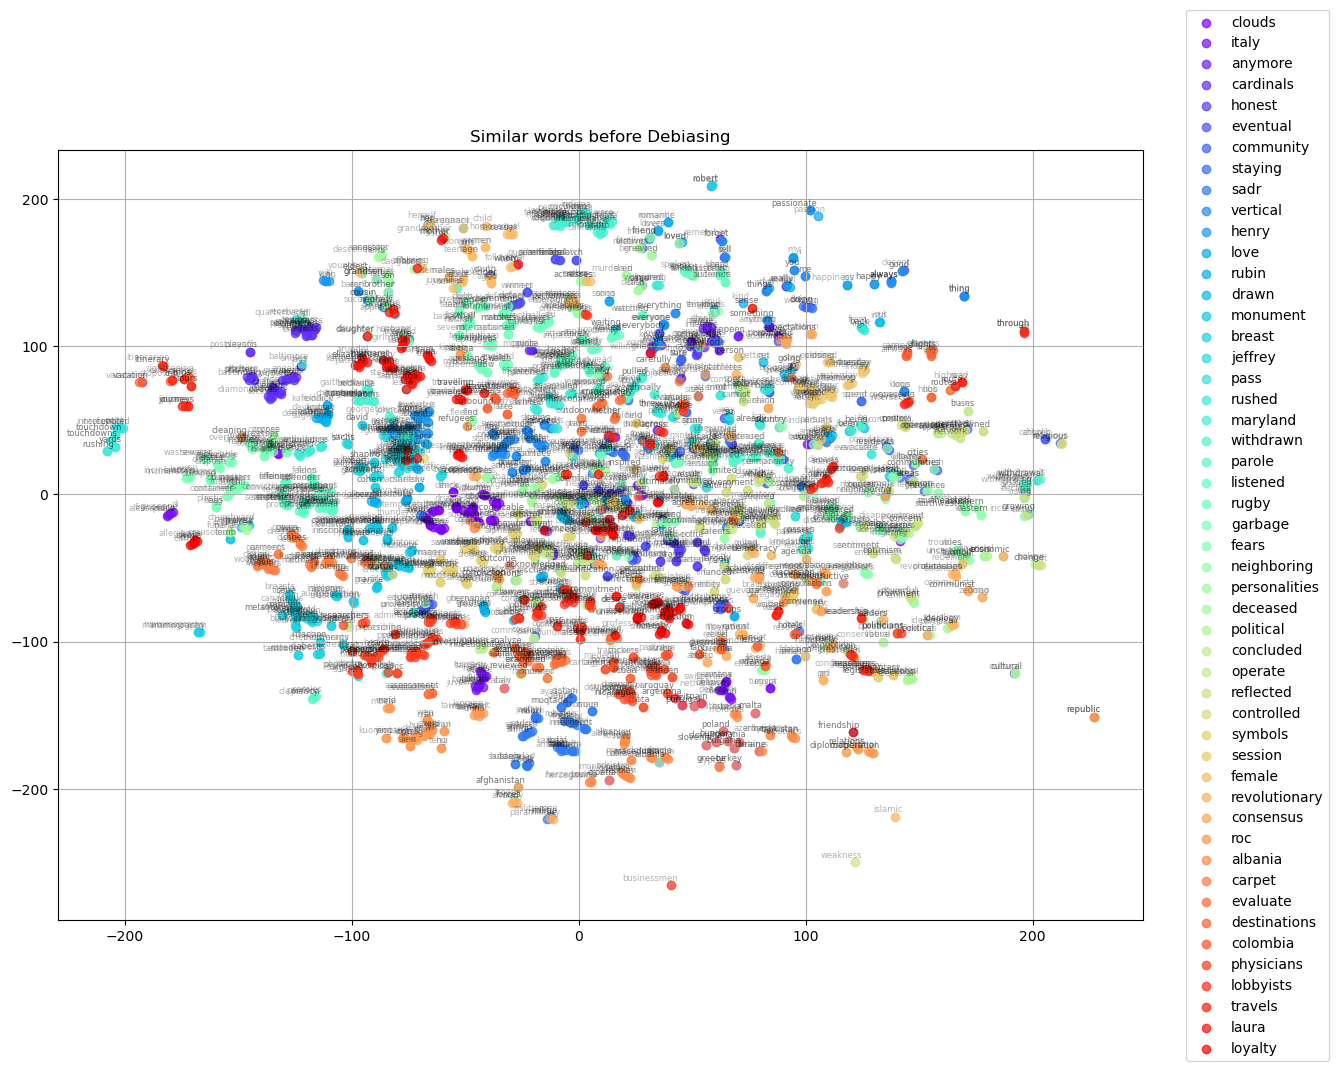

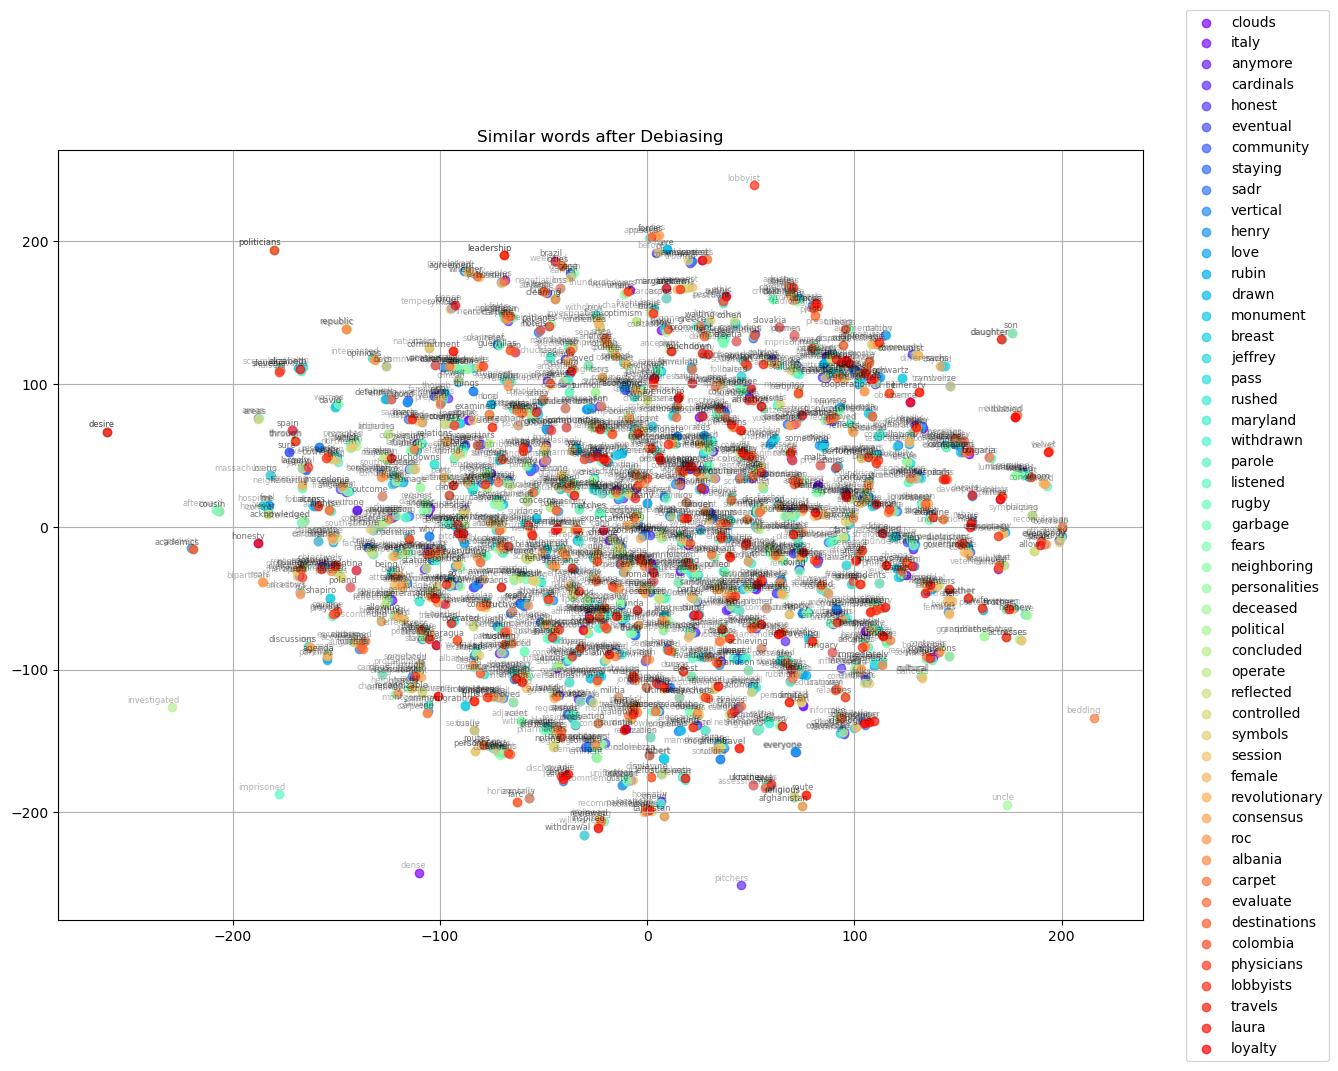

In [22]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

#Getting the Gensim models to plot the neighbors
gender_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 300)
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)

keys = random_words
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, model_original, gender_debiased, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7, "Figures/Random_words_neighbors_before_debiasing.png")
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7, "Figures/Random_words_neighbors_after_debiasing.png")



 ### Distribution of neighbors: A two sample permutation test of the original neighbors pre- and post-debiasing
 The distribution of original neighbors to the random words appears to be very different in the debiased embeddings than in the original embeddings, but how different is it? 

In [72]:
#get a list with the first value of each tuple in the neighbors list
neighbors_words = []
for random_word in k_neigh:
    for i in range(len(k_neigh[random_word])):
        neighbors_words.append(k_neigh[random_word][i][0])



In [73]:
from Scripts.Evaluation import p_value_perm_neighs
#Getting the p-value for the two sample permutation test
p_value_perm_neighs(random_words, neighbors_words, dict_vec_cleaned,
                    deb_dict_gender)


original mean: 0.012657707399081399
num of samples 250000


100%|██████████| 250000/250000 [1:52:19<00:00, 37.10it/s]


0.497524

But when running it with another sample of random words, then the P-value was different:

In [ ]:
#On a previous attempt, for the following random words, I got a p-value of 0.29
random_words=['athen', 'zindel', 'wyattville', 'fmqb', 'zinfandel', 'nektar',
     'mantovani', 'oper', 'corio', 'pavletic', 'kittanning', 'summeren',
       'monsey', 'chink', 'aurunci', 'robbia', 'frisky', 'meekness',
      'wipo', 'mbomo', 'breakpoints', 'jaegerstaetter', 'wor', 'jetpack',
      'kucharczyk', 'mythago', 'boonton', 'ywain', 'eraiba', 'obiko',
       'bongiovanni', 'zalman', 'stowarzyszenie', 'prophets', 'katju',
       'family', 'tests', 'longmei', 'espagnol', 'tanney', 'luiza',
       'rasin', 'hassim', 'nava', 'warlick', 'monda', 'grimme', 'ansatz',
       'puteaux', 'joanette']

neighbors = get_k_nearest_neighbors(random_words,
                                    dict_vec_cleaned, vocab_cleaned,
                                    vectors_cleaned, word2idx_cleaned, k=50)

#get a list with the first value of each tuple in the neighbors list
neighbors_words = []
for random_word in k_neigh:
    for i in range(len(neighbors[random_word])):
        neighbors_words.append(neighbors[random_word][i][0])

p_value_perm_neighs(random_words, neighbors_words, dict_vec_cleaned,
                    deb_dict_gender)


 ### Punctuation test


In [29]:
# Getting the vocabulary of punctuation marks and numbers
vocab_punct, vectors_punct, word2idx_punct, dict_vec_punct = glove.limit_vocab(vectors, word2idx, vocab, exclude=vocab_cleaned, exclude_punct=False)
print('Shape of the vectors of words with punctuation marks or numbers:', vectors_punct.shape)
print(type(vectors_punct))

#add the vectors_punct to the deb_vect_gender
all_vectors = np.vstack([deb_vect_gender, vectors_punct])
all_words = deb_vocab_gender+vocab_punct
#paste the two dictionaries together
w2i_all = {w: i for i, w in enumerate(all_words)}
dict_all = get_debiased_dict(all_vectors, w2i_all)

#Getting the neighbors to 50 random words with punctuation marks or numbers
df_punct = get_df_random_words_neighbor_analysis_values(
    vocab_punct[:10000], vocab, dict_vectors, vectors, word2idx,
    dict_all, all_words, all_vectors, w2i_all,
    k=50, num_iterations=1, size_random_set=50)


Size of limited vocabulary: 72815
Shape of the vectors of words with punctuation marks or numbers: (72815, 300)
<class 'numpy.ndarray'>


100%|██████████| 50/50 [02:00<00:00,  2.42s/it]
50it [01:38,  1.96s/it]


In [30]:
#Getting a plot of the frequency of the original neighbors in the new 50-vicinity
plot_frequency_original_neighbors(df_punct[['word', 'freq']], 'Frequency original Neighbors', "words with punctuation and numbers")



In [31]:
#Getting the average distance of the original neighbors in the original and debiased embeddings
plot_average_distance(df_punct, 
                      'Average distances from neighbors of words with punctuation and numbers', 'Words containing punctuation and numbers')


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Matplotlib currently does not support Devanagari natively.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2324 (\N{DEVANAGARI LETTER AU}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/s

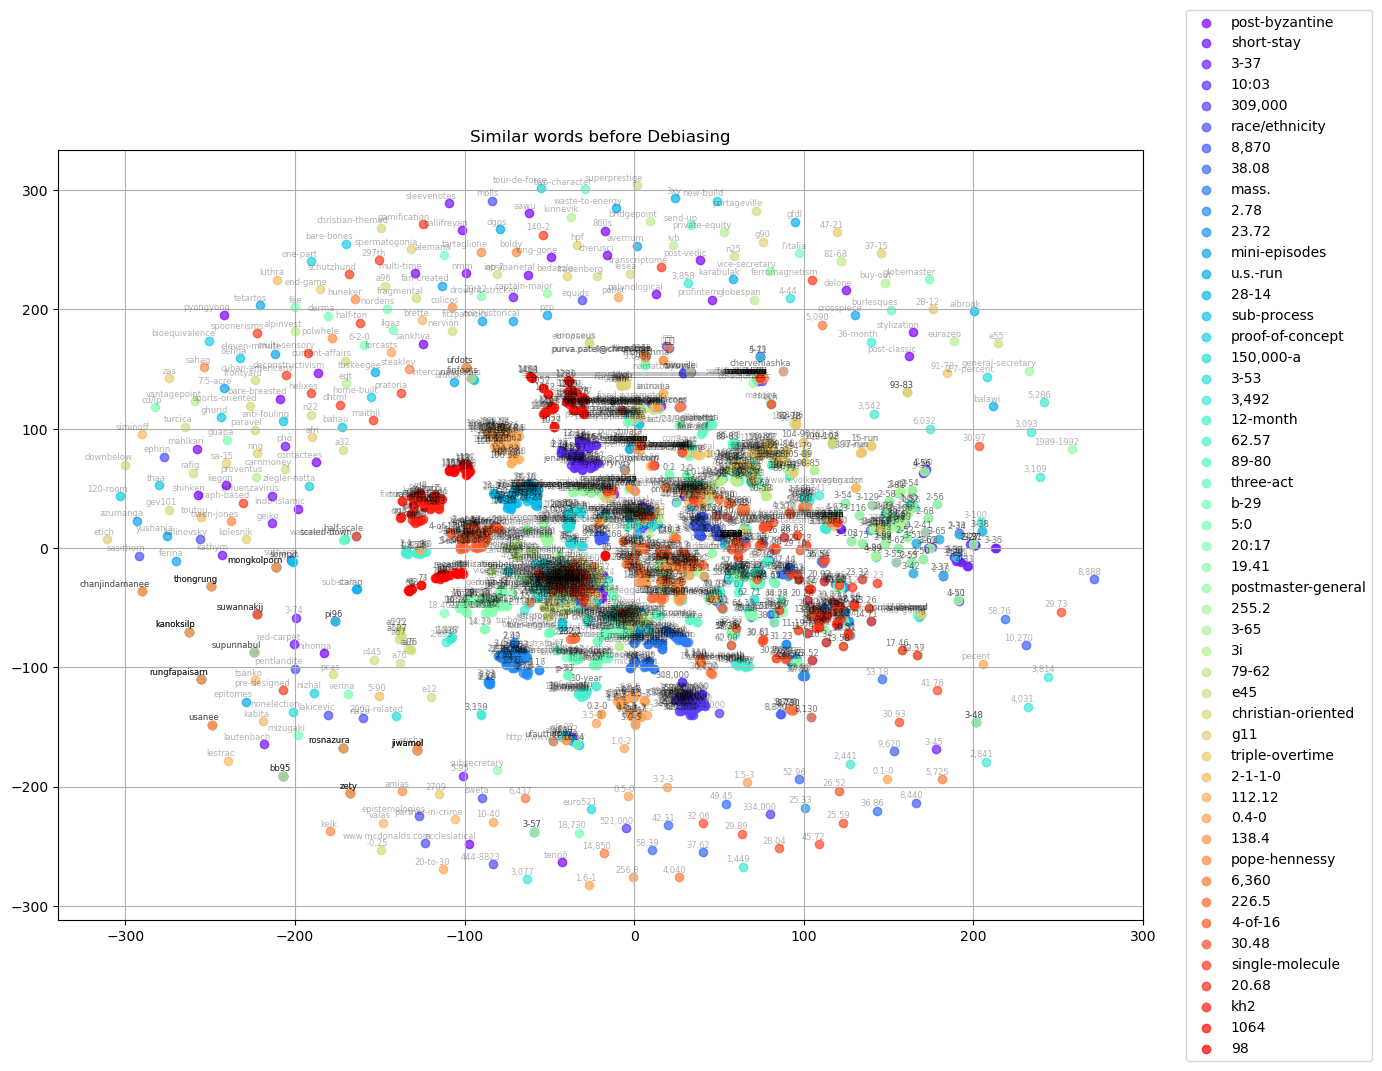

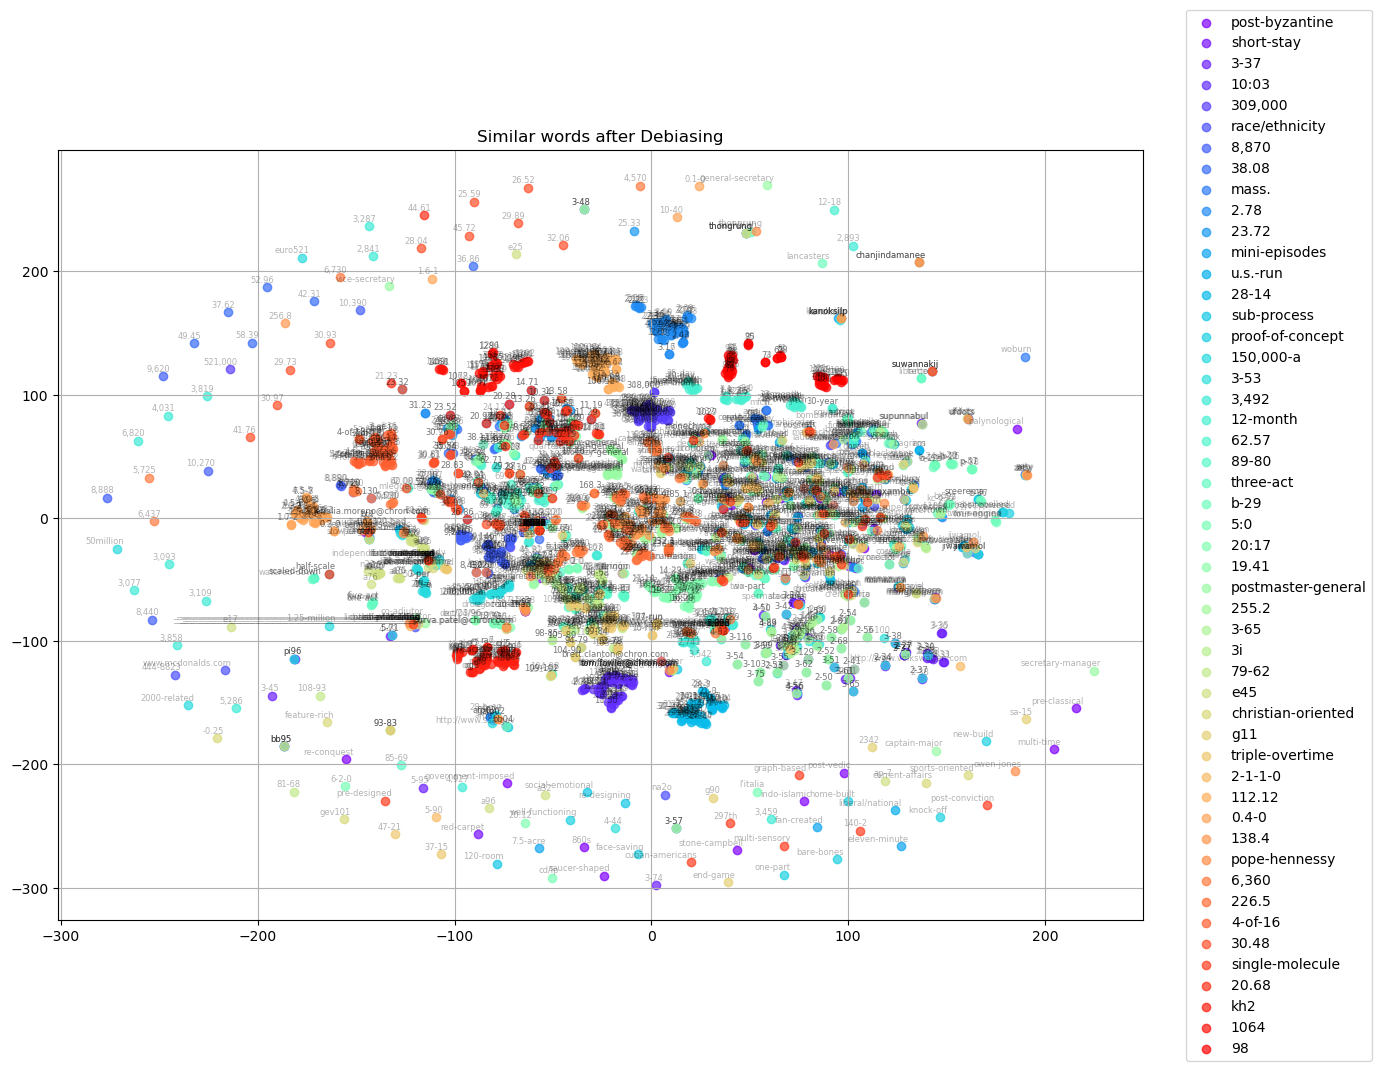

In [32]:
#Plotting the clusters of neighbors to random words with punctuation marks or numbers pre and post debiasing
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

#Getting the Gensim models to plot the neighbors
model_debiased_punct = create_KeyedVectors(all_vectors, all_words, 300)

keys = list(df_punct['word'])
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, glove.model, model_debiased_punct, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)



 ### Neutral words

In [33]:
#Getting the gender direction to find the words that initially had a bias score close to 0 (that were neutral)
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)

direct_gender_bias_original = compute_similarity_to_bias_direction(
    dict_vec_cleaned, gender_direction)


#transform the values of the direct_gender_bias_original dictionary to float
for word, value in direct_gender_bias_original.items():
    direct_gender_bias_original[word]=float(value)

#Getting the words that are closer to be neutral in the original embeddings
orig_neutral = [word for word in direct_gender_bias_original.keys()
              if np.abs(direct_gender_bias_original[word])<0.001]

#Some information about the words that are closer to be neutral in the original embeddings
print('words closer to be neutral in original embeddings:',len(orig_neutral))
print('first 10 neutral words:', orig_neutral[:10])


Length of vectors set: 22
Running PCA with 1 components
words closer to be neutral in original embeddings: 2984
first 10 neutral words: ['my', 'population', 'california', 'products', 'angeles', 'killing', 'cents', 'details', 'museum', 'separate']


In [34]:
#getting the neighbors to 50 random neutral words in the original embeddings, their proportion in the new 50-vicinity and the average distance
df_nt = get_df_random_words_neighbor_analysis_values(
    orig_neutral, vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned,
    deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender,
    k=50, num_iterations=1, size_random_set=50)


100%|██████████| 50/50 [01:20<00:00,  1.60s/it]
50it [01:20,  1.60s/it]


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 21496 (\N{CJK UNIFIED IDEOGRAPH-53F8}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.



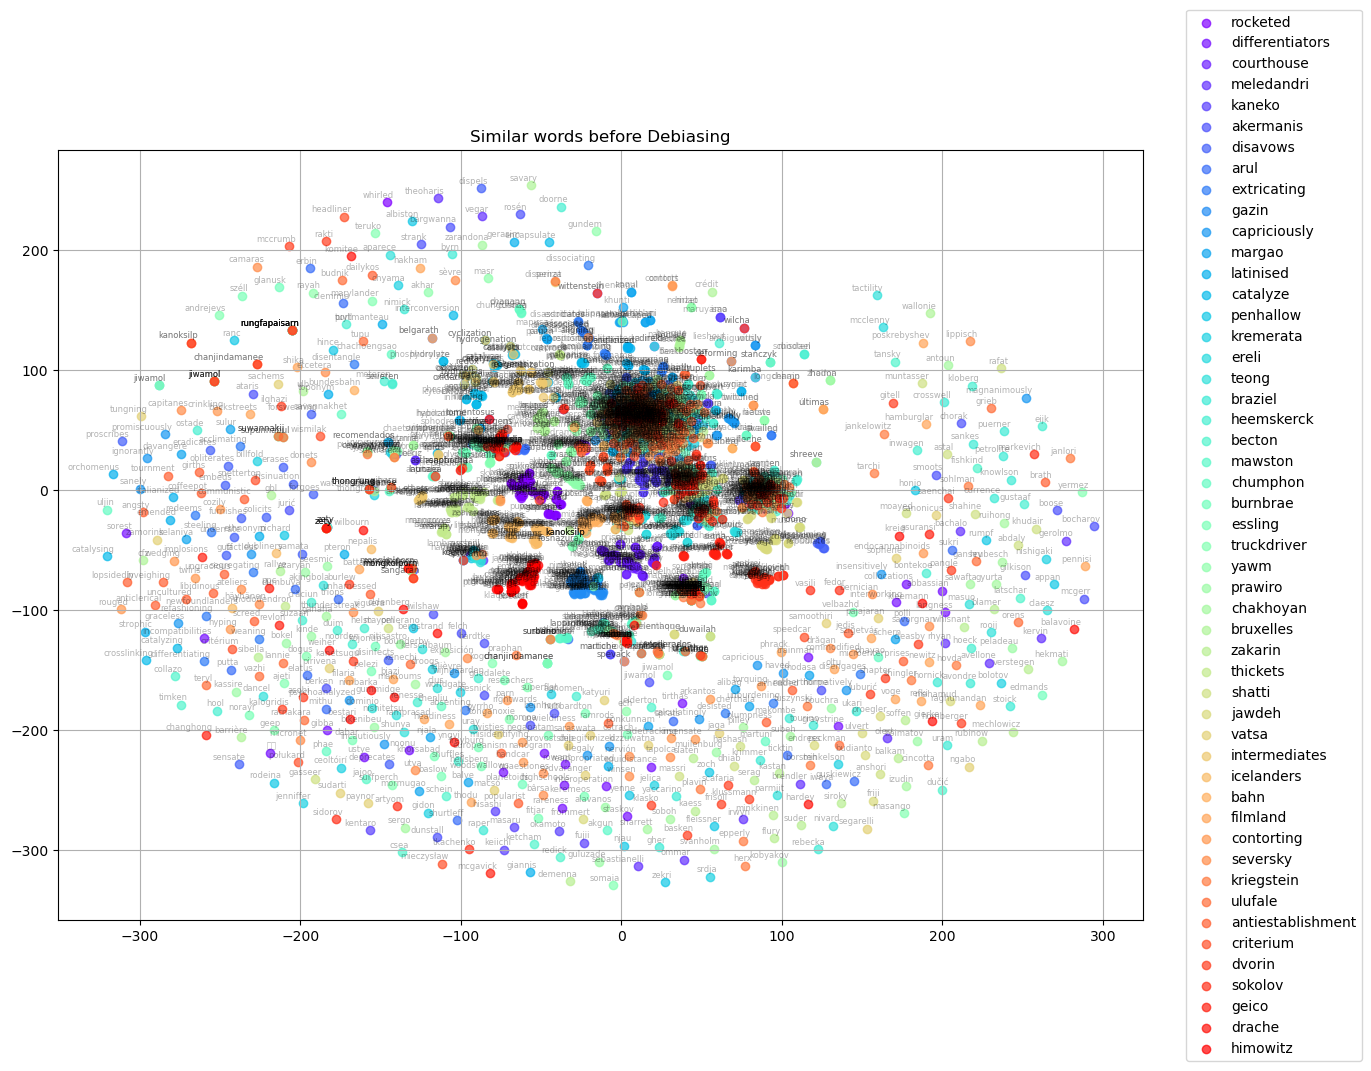

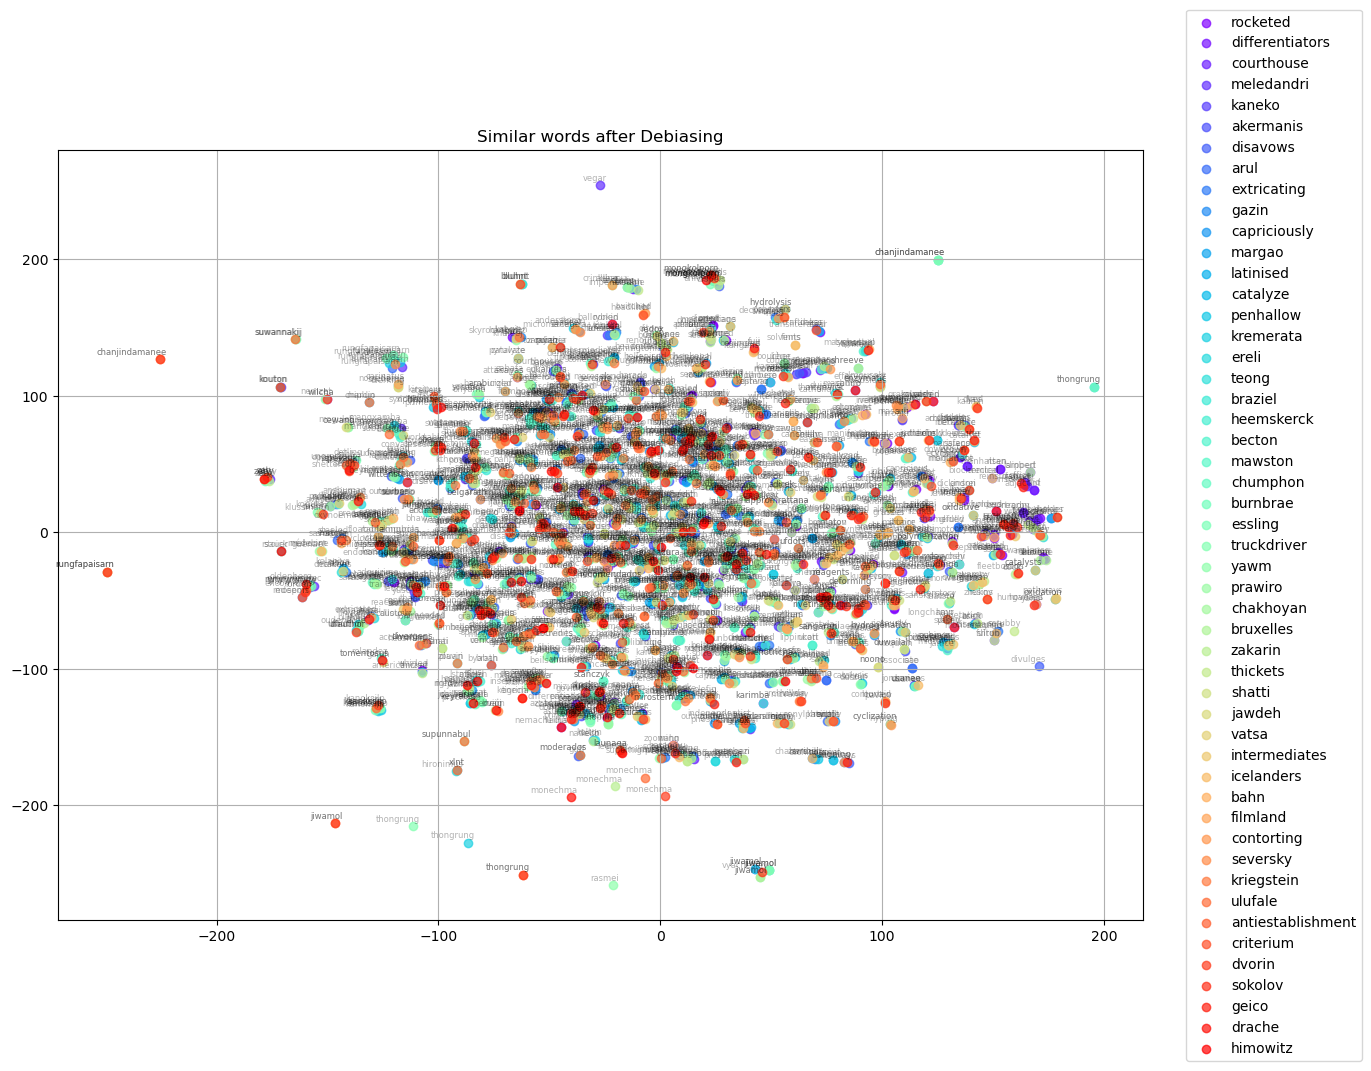

In [35]:
#Visualizing the clusters of original neighbors pre and post-
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

#Getting the Gensim models to plot the neighbors
model_original= create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)
model_debiased_gender=create_KeyedVectors(deb_vect_gender,deb_vocab_gender,300)

keys = list(df_nt['word'])
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, model_original, model_debiased_gender, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)



In [36]:
#getting the plot of the frequency of the original neighbors in the new 50-vicinity
plot_frequency_original_neighbors(df_nt[['word', 'freq']], "Frequencies of original neighbors to neutral words", 'words wih zero direct bias')


In [37]:
#Getting the average distance of the original neighbors in the original and debiased embeddings
plot_average_distance(df_nt,
                      'Average distances from neighbors of neutral words', 'words wih zero direct bias')



 ### Gendered words

In [40]:
#This time, we'll get the words that are more likely to be biased in the original embeddings
orig_biased=[word for word in direct_gender_bias_original.keys() 
              if np.abs(direct_gender_bias_original[word])>0.25]

#Some information on the set of biased words
print('Words closer to be biased in original embeddings:', len(orig_biased))
print('First 10 biased words:', orig_biased[:10])

#getting the df with the aggregate information on neighbors
df_bs = get_df_random_words_neighbor_analysis_values(
    orig_biased, vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned,
    deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender,
    k=50, num_iterations=1, size_random_set=50)

#remove duplicates from df_bs
df_bs = df_bs.drop_duplicates(subset=['word'])


Words closer to be biased in original embeddings: 2444
First 10 biased words: ['he', 'his', 'she', 'her', 'women', 'john', 'man', 'george', 'chairman', 'himself']


100%|██████████| 50/50 [01:19<00:00,  1.59s/it]
50it [01:19,  1.60s/it]


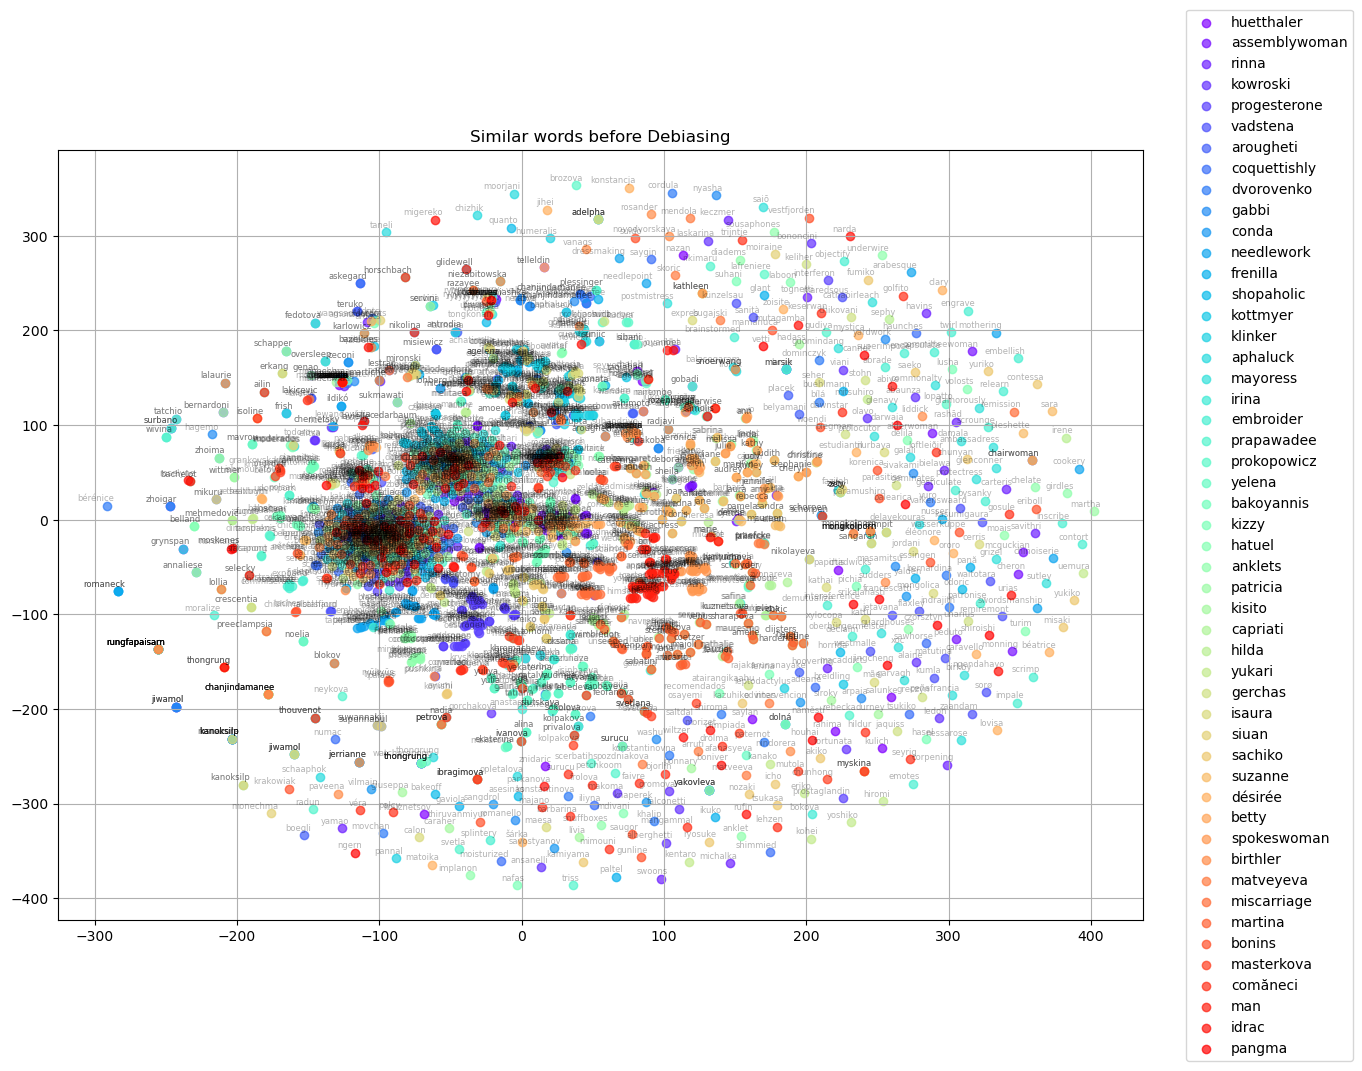

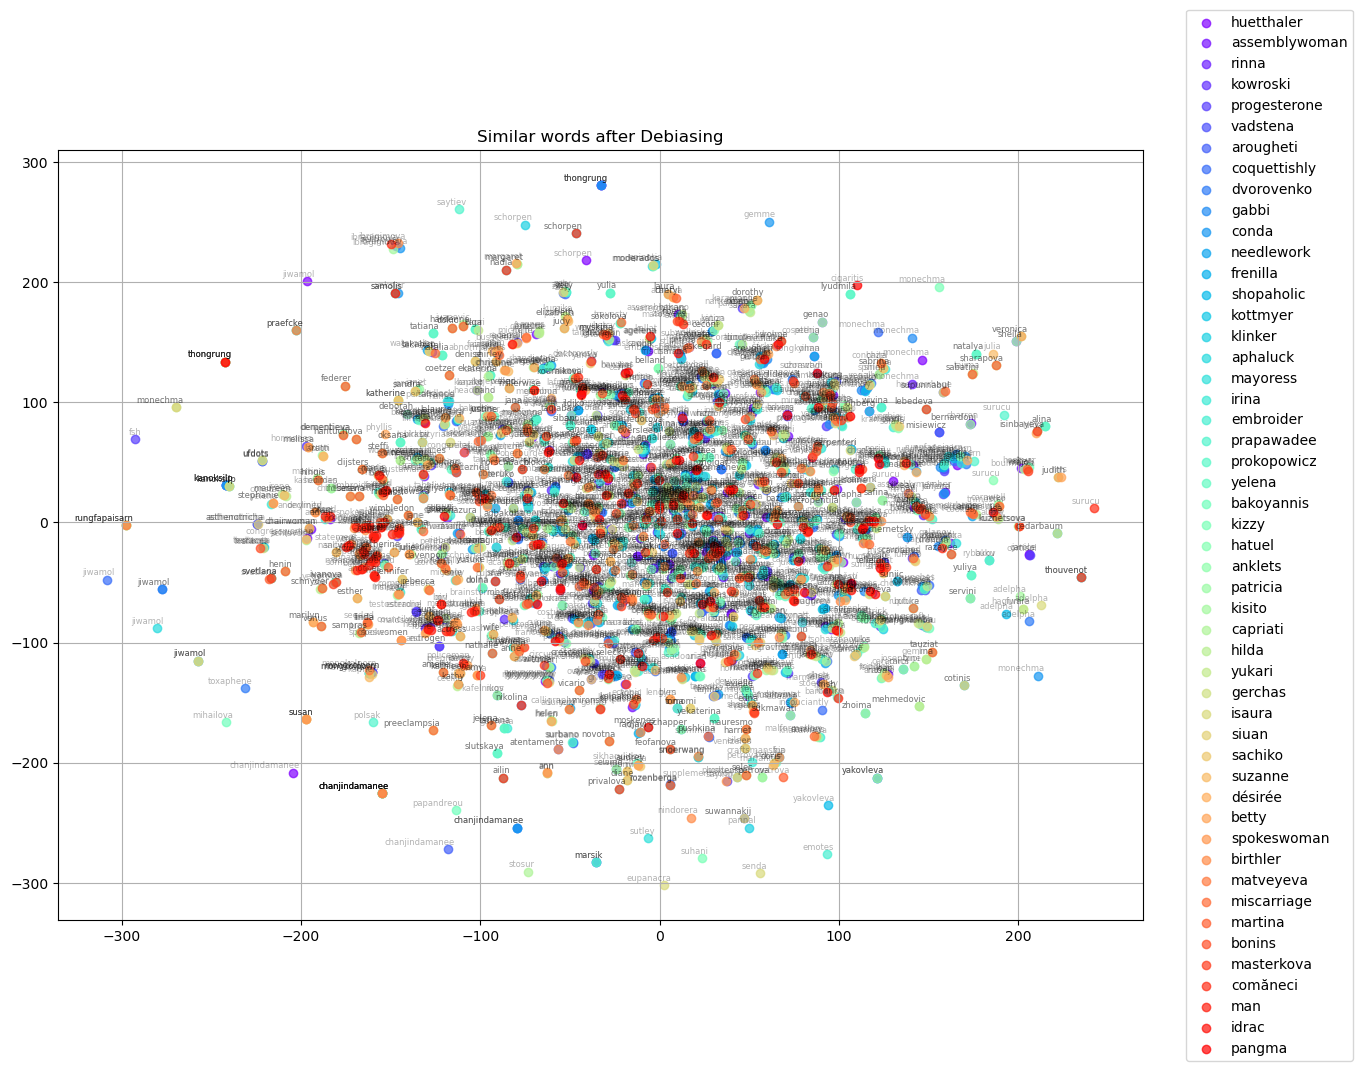

In [41]:
#Plots to inspect the neighbors of the biased words
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

keys = list(df_bs['word'])
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, model_original, model_debiased_gender, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)



In [42]:
#Getting the proportion of original neighbors in the new 50-vicinity
plot_frequency_original_neighbors(
    df_bs[['word', 'freq']], "Frequencies of original neighbors to neutral words", 'words wih zero direct bias')



In [43]:
#Getting the average distance of the original neighbors in the original and debiased embeddings
plot_average_distance(df_bs,
                      'Average distances from neighbors of neutral words', 'words wih zero direct bias')



 ### Occupations

In [45]:
#getting the occupations that are in the vocab_cleaned
occupations_in_vocab = [word for word in occupations if word in vocab_cleaned]
print(len(occupations_in_vocab))

#Getting the df with the aggregate information on neighbors from the occupation words
df_occ = get_df_random_words_neighbor_analysis_values(
    occupations_in_vocab, vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned,
    deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender,
    k=50, num_iterations=1, size_random_set=len(occupations_in_vocab))


59


100%|██████████| 59/59 [01:34<00:00,  1.61s/it]
59it [01:34,  1.59s/it]


In [49]:
#Plotting the proportion of original neighbors in the new 50-vicinity
plot_frequency_original_neighbors(
    df_occ[['word', 'freq']], "Frequencies of original neighbors to occupations", 'Occupations')

In [47]:
#Because the occupation words seem to retain more neighbors than the neutral words, let's look at Gonen's 'bias by neighbors' metric
from Scripts.Evaluation import bias_by_neighbors
#Getting the number of biased neighbors on the 50-vicinity of each occupation
bias_neigh = bias_by_neighbors(simple_gender_bias_original, gender_bias_after_debiasing, occupations_in_vocab, deb_dict_gender, deb_vocab_gender,
                  deb_vect_gender, deb_word2idx_gender, neighbours_num=50)

#get a dataframe of the bias by neighbors (bias_neigh)
df_bias_neigh=pd.DataFrame(bias_neigh, columns=['word', 'bias_original', 'bias_debiased', 'f', 'm'])
df_bias_neigh['diff_neigh']=df_bias_neigh['f']-df_bias_neigh['m']

#remove duplicates from df_bias_neigh
df_bias_neigh=df_bias_neigh.drop_duplicates(subset=['word'])

100%|██████████| 59/59 [01:33<00:00,  1.59s/it]


In [48]:
#plot the bias by neighbors: the number of feminine and masculine neighbors
fig1 = go.Figure()
# add a barplot with the f and m columns
fig1.add_trace(go.Bar(x=df_bias_neigh['word'],
                      y=df_bias_neigh['f'], name='Feminine Bias', 
                      marker_color='#a47c9b'))
fig1.add_trace(go.Bar(x=df_bias_neigh['word'],
                      y=df_bias_neigh['m'], name='Masculine Bias',
                      marker_color='#829e9a'))
#stack the bars
fig1.update_layout(barmode='stack')

#update the layout
fig1.update_layout(
    title='Bias by Neighbors',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of biased Neighbors',
        titlefont_size=16,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Occupations'
    ),
    #showlegend=False,
    plot_bgcolor='white',
    autosize=False,
    width=1200,
    height=500,
    margin=dict(
        
        b=200
    ),
    template='ggplot2'
)
fig1.show()


 ### Distribution of distances test

In [74]:
from Scripts.Evaluation import get_df_random_words_neighbor_analysis_values
#getting the frequencies of neighbors and the average distance of neighbors for 50 iterations
df_merged=get_df_random_words_neighbor_analysis_values(
    vocab_cleaned,vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50, num_iterations=50, size_random_set=50)

df_merged.to_csv("Data/df_merged_50x50neigh_final.csv", index=False)

#get the mean values from the dataframe
df_mean=df_merged[['freq','distance_original', 'distance_debiased', 'iteration']].groupby('iteration').agg('mean').reset_index()

#create a long format table of df_mean
df_mean_long=pd.melt(df_mean, id_vars=['iteration'], value_vars=['distance_original', 'distance_debiased', 'freq'])

100%|██████████| 50/50 [01:17<00:00,  1.56s/it]
50it [01:17,  1.55s/it]
100%|██████████| 50/50 [01:17<00:00,  1.55s/it]
50it [01:17,  1.54s/it]
100%|██████████| 50/50 [01:17<00:00,  1.55s/it]
50it [01:17,  1.55s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:16,  1.53s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:16,  1.53s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:16,  1.53s/it]
100%|██████████| 50/50 [01:17<00:00,  1.55s/it]
50it [01:17,  1.54s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:16,  1.54s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:17,  1.54s/it]
100%|██████████| 50/50 [01:17<00:00,  1.55s/it]
50it [01:16,  1.54s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:16,  1.54s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:16,  1.53s/it]
100%|██████████| 50/50 [01:17<00:00,  1.54s/it]
50it [01:16,  1.53s/it]
100%|██████████| 50/50 [01:17<00:00,  1.55s/it]
50it [01:16,  1.

In [79]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains('distance')], x="variable", y="value", points="all",
                title="Average cosine distance to neighbors before and after debiasing",
                labels={"variable": "Cosine Distance", "value": "Average Cosine Distance to Neighbors",
                        'distance_original':"Original Embeddings", 'distance_debiased':"Debiased Embeddings"},
             color_discrete_sequence=['#046f94'],
                template='ggplot2', 
                orientation='v',
                height=800, width=600)
#change y-axis range
fig.update_yaxes(range=[0.5, 0.95])
#save the figure
#fig.write_image("Figures/boxplot_distance_original_debiased_50x20neigh.png", engine='kaleido')
fig.show()

In [80]:


#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains(
    'freq')], x="variable", y="value", points="all",
    title="Distribution of original neighbors on 50-vicinity after debiasing",
    labels={"variable": "original neighbors", "value": "Frequency"},
    color_discrete_sequence=['#046f94'],
    template='ggplot2')
#update y-range
fig.update_yaxes(range=[0, 0.1])
fig.show()


In [85]:

#group by iteration to get mean values of all the columns except for the word
import plotly.express as px
mean_df = df_merged.groupby('iteration').mean()

mean_df['diff_distance'] = mean_df['distance_debiased'] - \
    mean_df['distance_original']


#use plotly to get a histogram of the difference values
fig = px.histogram(mean_df, x="diff_distance", nbins=20,
                   title="Distribution of the difference between the average cosine distance to neighbors",
                   labels={
                       "diff_distance": "Difference between the average cosine distance to neighbors"},
                   template='ggplot2',
                   color_discrete_sequence=['#046f94']
                   )
#add vertical line for the zero
fig.add_vline(x=0, line_width=3, line_dash="dash", line_color="#b2868e")
#update x-axis range
fig.update_xaxes(range=[0.25, 0.35])
fig.update_layout(bargap=0.01)



fig.show()


/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_1492/2987328127.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



 # Intersectional study
 Bias is not binary nor one dimensional, if clusters are shuffled, what is the effect of the shuffling on other social classes? Is there a way to measure it?

In [50]:
#Find the words in the female_vocab that are also in the embeddings
female_words_emb = [
    word for word in female_vocab if word in dict_vec_cleaned.keys()]
male_words_emb = [
    word for word in male_vocab if word in dict_vec_cleaned.keys()]

print('Number of female words in embeddings:', len(female_words_emb))
print('Number of male words in embeddings:', len(male_words_emb))



Number of female words in embeddings: 182
Number of male words in embeddings: 183


In [87]:
#Lists of names for validation
#Adapted from Caliskan et al., and Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Jamal', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],


}


In [52]:
#Find the words in the female_vocab that are also in the embeddings
names_white_emb = [
    word.lower() for word in names_ethnicity['White'] if word.lower() in dict_vec_cleaned.keys()]
names_black_emb = [
    word.lower() for word in names_ethnicity['Black'] if word.lower() in dict_vec_cleaned.keys()]

names_hispanic_emb = [
    word.lower() for word in names_ethnicity['Hispanic'] if word.lower() in dict_vec_cleaned.keys()]


print('Number of white names in embeddings:', len(names_white_emb))
print('Number of black names in embeddings:', len(names_black_emb))
print('Number of hispanic names in embeddings:', len(names_hispanic_emb))



Number of white names in embeddings: 48
Number of black names in embeddings: 39
Number of hispanic names in embeddings: 30


In [53]:
#getting the gender directions
gen_dir_centralized=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
#flattening them
gen_dir_centralized_flat=np.squeeze(gen_dir_centralized)


Length of vectors set: 22
Running PCA with 1 components


In [55]:

#Sanity check: are feminine names, feminine? and Masculine names, masculine?

#First getting the similarity scores
from Scripts.Evaluation import compute_gender_simple_bias, compute_similarity_to_bias_direction
similarity_centralized=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_centralized_flat)
simple_gender_bias=compute_gender_simple_bias(dict_vec_cleaned, dict_vec_cleaned['he'], dict_vec_cleaned['she'])
deb_similarity_centralized=compute_similarity_to_bias_direction(deb_dict_gender, gen_dir_centralized_flat)
deb_simple_gender_bias=compute_gender_simple_bias(deb_dict_gender, deb_dict_gender['he'], deb_dict_gender['she'])
from Scripts.Visualization import plot_top_biased_words
#getting the bias score for the names
df_names_white = utils.get_df_bias_scores(
    names_white_emb, similarity_centralized, simple_gender_bias)
df_names_black = utils.get_df_bias_scores(
    names_black_emb, similarity_centralized, simple_gender_bias)
df_names_hispanic = utils.get_df_bias_scores(
    names_hispanic_emb, similarity_centralized, simple_gender_bias)

#now the dataframe for the debiased embeddings
df_names_white_deb = utils.get_df_bias_scores(
    names_white_emb, deb_similarity_centralized, deb_simple_gender_bias)
df_names_black_deb = utils.get_df_bias_scores(
    names_black_emb, deb_similarity_centralized, deb_simple_gender_bias)
df_names_hispanic_deb = utils.get_df_bias_scores(
    names_hispanic_emb, deb_similarity_centralized, deb_simple_gender_bias)

#merging the dataframes
df_names_white_merged = pd.merge(df_names_white, df_names_white_deb,
                                 left_index=True, right_index=True, suffixes=('_orig', '_deb'))
df_names_black_merged = pd.merge(df_names_black, df_names_black_deb,
                                 left_index=True, right_index=True, suffixes=('_orig', '_deb'))
df_names_hispanic_merged = pd.merge(
    df_names_hispanic, df_names_hispanic_deb, left_index=True, right_index=True, suffixes=('_orig', '_deb'))

#Plotting the names and their bias scores
plot_top_biased_words(df_names_white, n_words=50, plt_title='White American Names')
plot_top_biased_words(df_names_black, n_words=50, plt_title='Black American Names')
plot_top_biased_words(df_names_hispanic, n_words=50, plt_title='Hispanic American Names')


 Let's first define the sets to be used at weat:

In [56]:
from Scripts.Evaluation import *
#The following lists of words were taken from the Caliskan et al. 2017 paper

career = ['executive', 'management', 'professional',
          'corporation', 'salary', 'office', 'business', 'career']
family = ['home', 'parents', 'children', 'family',
          'cousins', 'marriage', 'wedding', 'relatives']


low_wage_occupations = ['operator', 'laborer', 'cleaner', 'guard',
                        'plumber', 'janitor', 'fireman', 'waiter',
                        'maid', 'cook', 'clerk', 'assistant', 'mechanic',
                        'porter', 'electrician', 'carpenter', 'tailor',
                        'hairdresser', 'helper']


pleasant = ["caress", "freedom", "health", "love", "peace", "cheer",
            "friend", "heaven", "loyal", "pleasure", "diamond", "gentle",
            "honest", "lucky", "rainbow", "diploma", "gift", "honor",
            "miracle", "sunrise", "family", "happy", "laughter", "paradise", "vacation"]

unpleasant = ["abuse", "crash", "filth", "murder", "sickness", "accident", "death",
              "grief", "poison", "stink", "assault", "disaster",
              "hatred", "pollute", "tragedy", "bomb", "divorce", "jail",
              "poverty", "ugly", "cancer", "evil", "kill", "rotten", "vomit"]

music = ["bagpipe", "cello", "guitar", "lute", "trombone", "banjo", "clarinet", "harmonica",
         "mandolin", "trumpet", "bassoon", "drum", "harp", "oboe", "tuba", "bell", "fiddle",
         "harpsichord", "piano", "viola", "bongo", "flute", "horn", "saxophone", "violin", "voice"]
guns = ["arrow", "club", "gun", "missile", "spear", "axe", "dagger", "harpoon", "pistol", "sword",
        "blade", "dynamite", "hatchet", "rifle", "tank", "bomb", "firearm", "knife", "shotgun",
        "teargas", "cannon", "grenade", "mace", "slingshot", "whip"]



In [57]:
#Separating the names of women and men per race/ethnicity
male_black_names = names_black_emb[:10]
male_white_names = names_white_emb[:10]
female_black_names = names_black_emb[-10:]
female_white_names = names_white_emb[-10:]
female_hispanic_names = names_hispanic_emb[-10:]
male_hispanic_names = names_hispanic_emb[:10]


#printing the above lists of names
print("Male names; black ethnicity:", male_black_names)
print("Female names; black ethnicity:", female_black_names)
print("Male names; hispanic ethnicity:", male_hispanic_names)
print("Female names; hispanic ethnicity:", female_hispanic_names)
print("Male names; white ethnicity:", male_white_names)
print("Female names; white ethnicity:", female_white_names)



Male names; black ethnicity: ['alonzo', 'jamel', 'jamal', 'lerone', 'theo', 'alphonse', 'jerome', 'leroy', 'torrance', 'darnell']
Female names; black ethnicity: ['jasmine', 'latonya', 'tanisha', 'tia', 'lakisha', 'latoya', 'yolanda', 'malika', 'tawanda', 'yvette']
Male names; hispanic ethnicity: ['juan', 'josé', 'miguel', 'luís', 'jorge', 'santiago', 'matías', 'sebastián', 'mateo', 'nicolás']
Female names; hispanic ethnicity: ['sofía', 'isabella', 'valentina', 'camila', 'valeria', 'ximena', 'luciana', 'mariana', 'victoria', 'martina']
Male names; white ethnicity: ['adam', 'chip', 'harry', 'josh', 'roger', 'alan', 'frank', 'ian', 'justin', 'ryan']
Female names; white ethnicity: ['nancy', 'stephanie', 'ellen', 'lauren', 'peggy', 'colleen', 'emily', 'megan', 'rachel', 'wendy']


WEFAT for the selected categories for all male and female names

In [61]:
dict_scores={}

In [62]:
# Experiment 1:
# Guns and Music words
print('Female and male names with guns and music words')
pval_before=p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names+male_hispanic_names,
                    female_white_names+female_black_names+female_hispanic_names, guns, music)
pval_after= p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names+male_hispanic_names,
                    female_white_names+female_black_names+female_hispanic_names, guns, music)
print('Before Debiasing', pval_before)
print('After Debiasing',pval_after )

dict_scores['all_music_guns'] = [pval_before, pval_after]

Female and male names with guns and music words
num of samples 1000000
num of samples 1000000
Before Debiasing 0.838351
After Debiasing 0.00973


In [63]:
# Experiment 2:
# Pleasant and unpleasant words
print('Female and male names with pleasant and unpleasant words')
pval_before=p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, pleasant, unpleasant)
print('Before Debiasing', pval_before)
p_val_after = p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names+male_hispanic_names,
                                  female_white_names+female_black_names+female_hispanic_names, pleasant, unpleasant)

print('After Debiasing', p_val_after)
dict_scores['all_pleasant_unpleasant'] = [pval_before, p_val_after]


Female and male names with pleasant and unpleasant words
num of samples 1000000
Before Debiasing 0.076277
num of samples 1000000
After Debiasing 0.880367


In [64]:
# Experiment 3:
# career and family words
print('Female and male names with career and family words')
p_val_bef=p_value_sample_weat(dict_vec_cleaned,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, career, family)
print('Before Debiasing', p_val_bef)
p_val_aft=p_value_sample_weat(deb_dict_gender,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, career, family)
print('After Debiasing', p_val_aft)
dict_scores['all_career_family'] = [p_val_bef, p_val_aft]

Female and male names with career and family words
num of samples 1000000
Before Debiasing 0.0
num of samples 1000000
After Debiasing 0.171387


In [65]:
# Experiment 4:
# career and low_wage_occupations words
print('Female and male names with career and low wage occupations')

p_val_b=p_value_sample_weat(dict_vec_cleaned,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, career, low_wage_occupations)
print('Before Debiasing', p_val_b)

p_val_a = p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names+male_hispanic_names,
                              female_white_names+female_black_names+female_hispanic_names, career, low_wage_occupations)
print('After Debiasing',p_val_a )
dict_scores['all_career_low_wage'] = [p_val_b, p_val_a]

Female and male names with career and low wage occupations
num of samples 1000000
Before Debiasing 4.5e-05
num of samples 1000000
After Debiasing 0.009525


In [67]:
dict_scores

{'all_music_guns': [0.838351, 0.00973],
 'all_pleasant_unpleasant': [0.076277, 0.880367],
 'all_career_family': [0.0, 0.171387],
 'all_career_low_wage': [4.5e-05, 0.009525]}

 Only African-American names and European-American Names

In [66]:
# Experiment 1:
# Guns and Music
print('Female and male names with guns and music words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
      female_white_names+female_black_names, guns, music))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
      female_white_names+female_black_names, guns, music))


print('_________________________________________________________')
# Experiment 2:
# Pleasant and unpleasant words
print('Female and male names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
      female_white_names+female_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
      female_white_names+female_black_names, pleasant, unpleasant))


print('_________________________________________________________')
# Experiment 3:
# career and family words
print('Female and male names with career and family words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
      female_white_names+female_black_names, career, family))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
      female_white_names+female_black_names, career, family))

print('_________________________________________________________')
# Experiment 4:
# career and low_wage_occupations 
print('Female and male names with career and low-wage occupations')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
                     female_white_names+female_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
                     female_white_names+female_black_names, career, low_wage_occupations))



Female and male names with guns and music words
Before Debiasing
num of samples 1000000
0.359863
After Debiasing
num of samples 1000000
0.019912
_________________________________________________________
Female and male names with pleasant and unpleasant words
Before Debiasing
num of samples 1000000
0.220284
After Debiasing
num of samples 1000000
0.814952
_________________________________________________________
Female and male names with career and family words
Before Debiasing
num of samples 1000000
1e-06
After Debiasing
num of samples 1000000
0.163114
_________________________________________________________
Female and male names with career and low-wage occupations
Before Debiasing
num of samples 1000000
0.000788
After Debiasing
num of samples 1000000
0.016249


 ### Intersections

In [68]:
#Black and white names with career and family
print('Black and white male names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      male_black_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      male_black_names, career, family))
print('----------------------------------------------------')

#Black and white names with career and low-wage occupations
print('Black and white male names with career and low-wage occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      male_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      male_black_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white names with pleasant and unpleasant words
print('Black and white male names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      male_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      male_black_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white names with music and guns
print('Black and white male names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      male_white_names, male_black_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender,
      male_white_names, male_black_names, guns, music))



Black and white male names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 195744.72it/s]


num of samples 184756
0.1992411613154647
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 188872.90it/s]


num of samples 184756
0.3410335794236723
----------------------------------------------------
Black and white male names with career and low-wage occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 194942.72it/s]


num of samples 184756
0.0
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 194905.11it/s]


num of samples 184756
0.0025601333650869256
----------------------------------------------------
Black and white male names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 193500.68it/s]


num of samples 184756
0.0008281192491718807
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 191221.78it/s]


num of samples 184756
0.11043755006603304
----------------------------------------------------
Black and white male names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 194228.76it/s]


num of samples 184756
0.16658187014224166
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 193664.33it/s]

num of samples 184756
0.0028740609235965273


In [69]:
#Black and white female names with career and family
print('Black and white female names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, female_white_names,
      female_black_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, career, family))
print('----------------------------------------------------')

#Black and white female names with career and low wage occupations
print('Black and white female names with career and low-wage occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, female_white_names,
      female_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white female names with pleasant and unpleasant words
print('Black and white female names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, female_white_names,
      female_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white female names with music and guns
print('Black and white female names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      female_white_names, female_black_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, guns, music))



Black and white female names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 197102.09it/s]


num of samples 184756
0.8410985299530191
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 195245.77it/s]


num of samples 184756
0.010467860313061551
----------------------------------------------------
Black and white female names with career and low-wage occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 197415.22it/s]


num of samples 184756
3.247526467340709e-05
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 197083.14it/s]


num of samples 184756
4.330035289787612e-05
----------------------------------------------------
Black and white female names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 202467.01it/s]


num of samples 184756
0.0012069973370282968
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 197340.16it/s]


num of samples 184756
0.16180259369113859
----------------------------------------------------
Black and white female names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 202495.21it/s]


num of samples 184756
0.02562298382731819
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 198578.30it/s]

num of samples 184756
0.014029314338911861


In [70]:
#Black male and white female names with career and family
print('Black male and white female names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_black_names,
      female_white_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_black_names,
      female_white_names, career, family))
print('----------------------------------------------------')

#Black and white female names with career and low wage occupations
print('Black male and white female names with career and low-wage occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_black_names,
      female_white_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_black_names,
      female_white_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white female names with pleasant and unpleasant words
print('Black male and white female names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_black_names,
      female_white_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_black_names,
      female_white_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white female names with music and guns
print('Black male and white female names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      male_black_names, female_white_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender,
      male_black_names, female_white_names, guns, music))



Black male and white female names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 193380.16it/s]


num of samples 184756
0.0001840264998159735
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 191424.09it/s]


num of samples 184756
0.742243824287168
----------------------------------------------------
Black male and white female names with career and low-wage occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 194625.01it/s]


num of samples 184756
0.8989045010716837
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 199259.26it/s]


num of samples 184756
0.9645207733443028
----------------------------------------------------
Black male and white female names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 194933.30it/s]


num of samples 184756
0.9937160362856957
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 195047.91it/s]


num of samples 184756
0.9479746259932018
----------------------------------------------------
Black male and white female names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 200557.48it/s]


num of samples 184756
0.9126253003961983
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 193709.88it/s]

num of samples 184756
0.835994500855182


In [71]:
#Black female and white male names with career and family
print('Black female and white male names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      female_black_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      female_black_names, career, family))
print('----------------------------------------------------')

#Black and white female names with career and low wage occupations
print('Black female and white male names with career and low_wage_occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      female_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      female_black_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white female names with pleasant and unpleasant words
print('Black female and white male names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      female_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      female_black_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white female names with music and guns
print('Black female and white male names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      male_white_names, female_black_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender,
      male_white_names, female_black_names, guns, music))


Black female and white male names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 195136.67it/s]


num of samples 184756
0.0009580203078655091
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 200104.38it/s]


num of samples 184756
0.02463790079889151
----------------------------------------------------
Black female and white male names with career and low_wage_occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 194544.49it/s]


num of samples 184756
0.0
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 202700.24it/s]


num of samples 184756
5.412544112234515e-06
----------------------------------------------------
Black female and white male names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 203591.30it/s]


num of samples 184756
5.412544112234515e-05
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 196956.66it/s]


num of samples 184756
0.3161142263309446
----------------------------------------------------
Black female and white male names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 202078.99it/s]


num of samples 184756
0.05073718850808634
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 203071.91it/s]

num of samples 184756
0.00012448851458139384
